In [1]:
import pandas as pd
from itables import show
import pymannkendall as mk
import geopandas as gpd
import matplotlib.pyplot as plt


In [2]:
years = list(range(2000, 2021))  # 1999 to 2023
csv_directory = 'Pneuf_ls_npp'

df_compiled = pd.concat([pd.read_csv(f'{csv_directory}/LS_npp_mean_HUC12_{year}.csv') for year in years], 
                        ignore_index=True)

In [3]:
df_compiled.to_csv('NPP_ls.csv', index=False)

In [5]:
def compute_sen_slope(df, value_col, huc_col='huc12', year_col='Year'):
    """
    Computes Sen's slope and Mann-Kendall trend test for each HUC12.

    Parameters:
    - df: DataFrame with 'HUC12', 'year', and ET index columns
    - value_col: Name of the column to compute trend on (e.g., 'ET_index_unnormalized')

    Returns:
    - DataFrame with HUC12, sen_slope, trend direction, p-value
    """
    results = []

    for huc, group in df.groupby(huc_col):
        group_sorted = group.sort_values(year_col)
        series = group_sorted[value_col].values

        if len(series) >= 4 and not all(pd.isnull(series)):
            try:
                test_result = mk.original_test(series)
                results.append({
                    huc_col: huc,
                    f'{value_col}_slope': test_result.slope,
                    f'{value_col}_p': test_result.p,
                    f'{value_col}_trend': test_result.trend
                })
            except:
                results.append({
                    huc_col: huc,
                    f'{value_col}_slope': None,
                    f'{value_col}_p': None,
                    f'{value_col}_trend': None
                })
        else:
            results.append({
                huc_col: huc,
                f'{value_col}_slope': None,
                f'{value_col}_p': None,
                f'{value_col}_trend': None
            })

    return pd.DataFrame(results)


In [8]:
df_npp = compute_sen_slope(df_compiled,value_col="mean")

In [9]:
df_npp

,huc12,mean_slope,mean_p,mean_trend
0,170402080101,50.961878,0.002794,increasing
1,170402080102,52.434006,0.004122,increasing
2,170402080103,59.677465,0.032034,increasing
3,170402080104,53.974518,0.005997,increasing
4,170402080105,48.224204,0.010266,increasing
5,170402080106,52.310810,0.003399,increasing
6,170402080107,56.078881,0.005997,increasing
7,170402080108,56.796922,0.008611,increasing
8,170402080201,59.604784,0.001869,increasing
9,170402080202,57.471413,0.004122,increasing


In [10]:
gdf = gpd.read_file('../portneuf_huc12/portneuf_huc12.shp')

In [11]:
# Make sure HUC12 in shapefile and trend_df match in type
gdf['huc12'] = gdf['huc12'].astype(str)
df_npp['huc12'] = df_npp['huc12'].astype(str)

In [13]:
merged_gdf_irr = gdf.merge(df_npp, left_on='huc12', right_on='huc12')

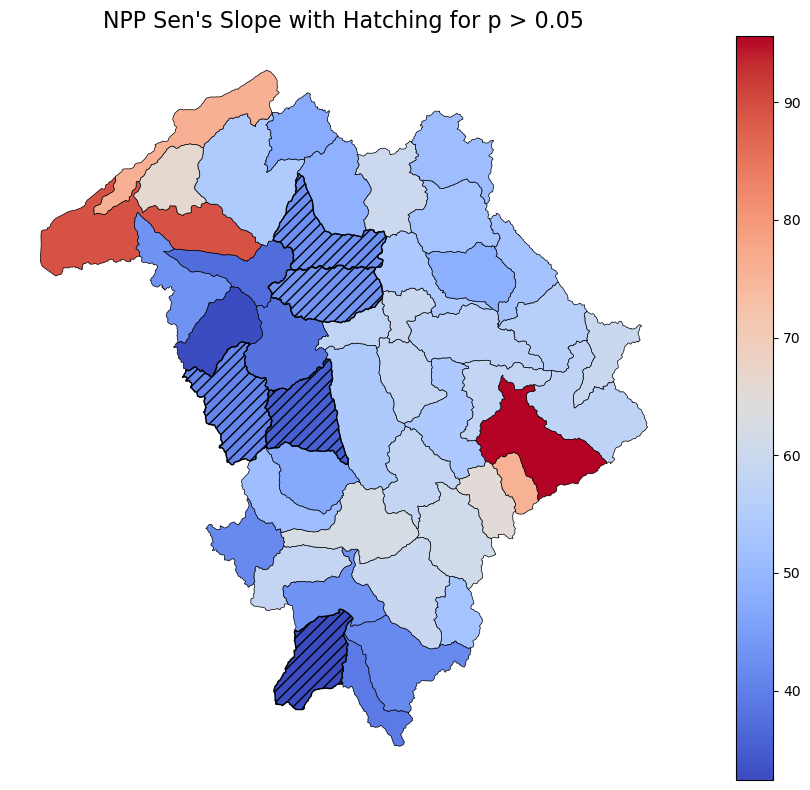

In [14]:
# Create masks for significance
sig = merged_gdf_irr['mean_p'] < 0.05
not_sig = ~sig

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot filled choropleth for all
merged_gdf_irr.plot(column='mean_slope', cmap='coolwarm', linewidth=0.5,
                edgecolor='black', legend=True, ax=ax)

# Hatch non-significant polygons
if not_sig.any():
    merged_gdf_irr[not_sig].plot(color='none', edgecolor='black', hatch='///', ax=ax)

ax.set_title("NPP Sen's Slope with Hatching for p > 0.05", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()